In [1]:
import pandas as pd
import numpy as np
import datetime
from pandas.tseries.offsets import *

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import *
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
import pickle
from lunar import *
%matplotlib inline

/Users/olivia/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/olivia/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/olivia/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20

In [2]:
df = pd.read_csv('train_20171226.csv')

/Users/olivia/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['sale_date']=pd.to_datetime(df['sale_date'], format='%Y%m')
df['price']=pd.to_numeric(df['price'],errors='coerce')

In [4]:
df_test = pd.read_csv('yancheng_testB_20180224.csv')

df_test.head()

,predict_date,class_id,predict_quantity
0,201712,281792,NaN
1,201712,682651,NaN
2,201712,603972,NaN
3,201712,221795,NaN
4,201712,482497,NaN


In [5]:
sale_class_date = df[['sale_quantity', 'class_id', 'sale_date']].groupby(['class_id','sale_date']).sale_quantity.agg('sum')

In [6]:
sale_class_date.head()

class_id  sale_date 
103507    2015-03-01     58
          2015-04-01    232
          2015-05-01    226
          2015-06-01    286
          2015-07-01    297
Name: sale_quantity, dtype: int64

In [7]:
df.head()

,sale_date,class_id,sale_quantity,brand_id,compartment,type_id,level_id,department_id,TR,gearbox_type,...,car_width,car_height,total_quality,equipment_quality,rated_passenger,wheelbase,front_track,rear_track,Unnamed: 32,Unnamed: 33
0,2016-09-01,289403,94,12,2,1,1,1,6,MT,...,1833,1545,1695,1320,5,2700,1556,1562,NaN,NaN
1,2016-09-01,745137,435,637,3,2,1,2,6,DCT,...,1823,1483,1711,1336,5,2648,1553,1544,NaN,NaN
2,2016-09-01,714860,180,831,3,2,2,3,6,AT,...,1815,1465,1860,1459,5,2770,1579,1589,NaN,NaN
3,2016-09-01,175962,40,750,3,2,1,4,6,AT,...,1706,1469,1625,1145,5,2603,1460,1500,NaN,NaN
4,2016-09-01,270690,19,98,2,3,3,1,5,MT,...,1685,1850,1825,1236,5,2720,1420,1440,NaN,NaN


## step 1

In [8]:
def quantity_feature(data, months, end_date):
    start_date = end_date + DateOffset(months=-months)
    data_temp = data[(data['sale_date']>=start_date) & (data['sale_date']<end_date)]
    result = data_temp.groupby(['class_id']).sale_quantity.agg({'mean%d'%months:'mean',
                                                                'median%d'%months: 'median',
                                                                'min%d'%months: 'min',
                                                                'max%d'%months: 'max',
                                                                'std%d'%months: 'std',
                                                                'count%d'%months: 'count',
                                                                'skew%d'%months: 'skew'})
    result['date'] = end_date
    return result

In [9]:
def ratio_feature(data):
    data['mean2_3'] = data['mean2']/(data['mean3']+1)
    data['mean2_6'] = data['mean2']/(data['mean6']+1)
    data['mean2_12'] = data['mean2']/(data['mean12']+1)
    data['mean3_6'] = data['mean3']/(data['mean6']+1)
    data['mean3_12'] = data['mean3']/(data['mean12']+1)
    return data

In [10]:
sale_class_date.head()

class_id  sale_date 
103507    2015-03-01     58
          2015-04-01    232
          2015-05-01    226
          2015-06-01    286
          2015-07-01    297
Name: sale_quantity, dtype: int64

In [11]:
reset_scd = sale_class_date.reset_index()
lagging_features = []

for date in df['sale_date'].dt.date.unique():
    month_feature = []
    for month in [2,3,6,12,18,24,100]:
        month_feature.append(quantity_feature(reset_scd, month, date))
    temp = pd.concat(month_feature, axis=1)
    temp = temp.loc[:,~temp.columns.duplicated()]
    lagging_features.append(temp.copy())


/Users/olivia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


In [12]:
lagging_features_df = pd.concat(lagging_features, axis=0).reset_index()
lagging_features_df = ratio_feature(lagging_features_df)

In [13]:
lagging_features_df.tail()

,class_id,mean2,median2,min2,max2,std2,count2,skew2,date,mean3,...,min100,max100,std100,count100,skew100,mean2_3,mean2_6,mean2_12,mean3_6,mean3_12
5476,953842,1244.5,1244.5,792.0,1697.0,639.931637,2.0,NaN,2016-08-01,1134.333333,...,9,1697,630.483201,6,0.958116,1.096154,1.946559,1.946559,1.774244,1.774244
5477,961362,52.0,52.0,52.0,52.0,0.000000,2.0,NaN,2016-08-01,59.000000,...,5,182,37.919550,55,1.113821,0.866667,0.631579,0.917647,0.716599,1.041176
5478,961962,143.0,143.0,127.0,159.0,22.627417,2.0,NaN,2016-08-01,155.333333,...,5,450,91.252331,55,1.087682,0.914712,0.749345,0.889580,0.813974,0.966304
5479,963845,242.0,242.0,242.0,242.0,0.000000,2.0,NaN,2016-08-01,248.666667,...,55,449,79.383719,22,0.368084,0.969292,0.947781,0.931964,0.973890,0.957638
5480,978089,502.0,502.0,474.0,530.0,39.597980,2.0,NaN,2016-08-01,579.666667,...,18,1284,253.079927,24,0.596770,0.864524,0.842046,0.732579,0.972323,0.845920


In [14]:
cols = ['current_sale','last_month_sale','last_year_sale','e_year','e_month',
        'month','year','class_id','last_month_price','last_year_price', 'price_delta', 
        'holidays','holiday_importance','weekend','length','workday','virtual_date']
dataset = {}
for c in cols:
    dataset[c]=[]

In [15]:
core_cols = ['current_sale','last_month_sale','last_year_sale','last_3m_avg','e_year','e_month',
            'last_month_price','last_year_price','price_delta','holidays','holiday_importance']

In [16]:
price_date = df[['price','class_id','sale_date']].groupby(['class_id','sale_date']).price.agg('mean')

In [17]:
holiday_df = pd.read_csv('holiday.csv')
holiday_df['date'] = pd.to_datetime(holiday_df['date'],format='%Y%m')


In [18]:
holiday_df.head()

,date,holidays,important
0,2012-01-01,7,1
1,2012-02-01,0,0
2,2012-03-01,0,0
3,2012-04-01,4,1
4,2012-05-01,1,1


In [19]:
for idx, row in holiday_df.iterrows():
    if row['important']==1:
        if row.date.month in [4,5]:
            holiday_df.loc[idx, 'important'] = 2
        if row.date.month in [9,10]:
            holiday_df.loc[idx, 'important'] = 3

In [20]:
holiday_df.set_index('date', inplace=True)

In [21]:
type_cols = ['class_id', 'TR', 'gearbox_type',
       'displacement', 'if_charging', 'price_level','driven_type_id',
       'fuel_type_id', 'newenergy_type_id', 'emission_standards_id',
       'if_MPV_id', 'if_luxurious_id', 'power', 'cylinder_number']
class_type = df[type_cols].drop_duplicates().groupby(['class_id']).count()
class_features = pd.DataFrame()
class_features['subtype_count'] = class_type['TR']
price_level_cols = ['class_id', 'price_level']
class_plevel = df[price_level_cols].drop_duplicates().groupby(['class_id']).count()
class_features['pricelevel_count'] = class_plevel['price_level']

In [22]:
class_features.head()

,subtype_count,pricelevel_count
class_id,,
103507,23,2
124140,13,1
125403,19,3
136916,24,3
169673,1,1


In [23]:
count = 0
max_value = sale_class_date.max()
for c in sale_class_date.index.levels[0]:
    for t in sale_class_date[c].index:
        count +=1
        dataset['current_sale'].append(sale_class_date[c][t])
        dataset['month'].append(t.month)
        dataset['year'].append(t.year)
        dataset['class_id'].append(c)
        dataset['virtual_date'].append(t)
        l3_total, l3_count = 0, 0
        
        last_month = t + DateOffset(months=-1)
        if last_month in sale_class_date[c].index:
            dataset['last_month_sale'].append(sale_class_date[c][last_month])
            l3_total += sale_class_date[c][last_month]
            l3_count += 1
        else:
            dataset['last_month_sale'].append(np.nan)
            
        last_year = t + DateOffset(years = -1)
        if last_year in sale_class_date[c].index:
            dataset['last_year_sale'].append(sale_class_date[c][last_year])
        else:
            dataset['last_year_sale'].append(np.nan)
            
        lalm = last_year + DateOffset(months = -1)
        if last_month in sale_class_date[c].index and last_year in sale_class_date[c].index and lalm in sale_class_date[c].index:
            dataset['e_year'].append(np.minimum(max_value,sale_class_date[c][last_month]*sale_class_date[c][last_year]/sale_class_date[c][lalm]))
        else:
            dataset['e_year'].append(np.nan)
            
        last_two_month = last_month + DateOffset(months = -1)
        if last_month in sale_class_date[c].index and last_two_month in sale_class_date[c].index:
            dataset['e_month'].append(np.minimum(max_value,sale_class_date[c][last_month]*sale_class_date[c][last_month]/sale_class_date[c][last_two_month]))
        else:
            dataset['e_month'].append(np.nan)
            
        if last_month in price_date[c].index:
            dataset['last_month_price'].append(price_date[c][last_month])
        else:
            dataset['last_month_price'].append(np.nan)
            
        if last_year in price_date[c].index:
            dataset['last_year_price'].append(price_date[c][last_year])
        else:
            dataset['last_year_price'].append(np.nan)
            
        dataset['price_delta'].append(dataset['last_month_price'][-1] - dataset['last_year_price'][-1])
        
        dataset['holidays'].append(holiday_df.loc[t,'holidays'])
        dataset['holiday_importance'].append(holiday_df.loc[t,'important'])
        
        temp = t
        weekend = 0
        length = 0
        while temp.month==t.month:
            length+=1
            if temp.weekday() >=5:
                weekend+=1
            temp += DateOffset(days=1)
        dataset['weekend'].append(weekend)
        dataset['length'].append(length)
        dataset['workday'].append(length-weekend-holiday_df.loc[t,'holidays'])
print(count)

5587


In [24]:
data_df = pd.DataFrame(dataset, columns=cols)

In [25]:
data_df['virtual_date'] = data_df['virtual_date'].dt.date

In [26]:
# cvt = LunarSolarConverter()
# data_df['lunar_month']=data_df['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,1)).lunarMonth)
# data_df['lunar_year']=data_df['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,1)).lunarYear)

In [27]:
data_df['sin_month'] = np.sin(data_df['month']*np.pi/12)
# data_df['sin_l_month'] = np.sin(data_df['lunar_month']*np.pi/12)

In [28]:
# 品种和价格
#data_df = data_df.merge(class_features.reset_index(), on='class_id')

In [29]:
data_df.columns

Index(['current_sale', 'last_month_sale', 'last_year_sale', 'e_year',
       'e_month', 'month', 'year', 'class_id', 'last_month_price',
       'last_year_price', 'price_delta', 'holidays', 'holiday_importance',
       'weekend', 'length', 'workday', 'virtual_date', 'sin_month'],
      dtype='object')

In [30]:
lagging_features_df.columns

Index(['class_id', 'mean2', 'median2', 'min2', 'max2', 'std2', 'count2',
       'skew2', 'date', 'mean3', 'median3', 'min3', 'max3', 'std3', 'count3',
       'skew3', 'mean6', 'median6', 'min6', 'max6', 'std6', 'count6', 'skew6',
       'mean12', 'median12', 'min12', 'max12', 'std12', 'count12', 'skew12',
       'mean18', 'median18', 'min18', 'max18', 'std18', 'count18', 'skew18',
       'mean24', 'median24', 'min24', 'max24', 'std24', 'count24', 'skew24',
       'mean100', 'median100', 'min100', 'max100', 'std100', 'count100',
       'skew100', 'mean2_3', 'mean2_6', 'mean2_12', 'mean3_6', 'mean3_12'],
      dtype='object')

In [31]:
data_df = data_df.merge(lagging_features_df, left_on=['class_id','virtual_date'], right_on=['class_id','date'], 
                        how='left')

In [32]:
data_df.drop(['virtual_date','date'], axis=1, inplace=True)

In [33]:
with open('data_df.pkl', 'wb') as f:
    pickle.dump(data_df, f, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
data_df.tail()

,current_sale,last_month_sale,last_year_sale,e_year,e_month,month,year,class_id,last_month_price,last_year_price,...,min100,max100,std100,count100,skew100,mean2_3,mean2_6,mean2_12,mean3_6,mean3_12
5582,381,512.0,474.0,330.187755,562.540773,6,2017,978089,6.4,6.6,...,18.0,1284.0,230.822508,34.0,0.827178,0.959451,0.809156,0.898072,0.841699,0.934190
5583,270,381.0,530.0,426.012658,283.517578,7,2017,978089,8.9,8.9,...,18.0,1284.0,229.211069,35.0,0.873149,0.983480,0.903541,0.831858,0.916695,0.843968
5584,419,270.0,521.0,265.415094,191.338583,8,2017,978089,7.4,7.9,...,18.0,1284.0,230.553308,36.0,0.885815,0.837479,0.729548,0.631937,0.868883,0.752629
5585,401,419.0,474.0,381.201536,650.225926,9,2017,978089,7.1,8.9,...,18.0,1284.0,228.175542,37.0,0.927671,0.963187,0.794389,0.680046,0.822444,0.704063
5586,400,401.0,503.0,425.533755,383.773270,10,2017,978089,7.1,7.4,...,18.0,1284.0,226.122056,38.0,0.969529,1.125343,1.002037,0.819181,0.887984,0.725941


In [35]:
data_df.shape

(5587, 71)

In [36]:
data_df['mean6'].isnull().sum()

147

## CV

In [37]:
from sklearn.neural_network import MLPRegressor

In [38]:
validation_df = data_df[(data_df['month']==10)&(data_df['year']==2017)]

train_df = data_df[~((data_df['month']==10)&(data_df['year']==2017))]

train_X = train_df.drop(['current_sale'], axis=1)
train_Y = train_df['current_sale']

In [39]:
test_X = validation_df.drop(['current_sale'], axis=1)
test_Y = validation_df['current_sale']

In [40]:
train_X.head()

,last_month_sale,last_year_sale,e_year,e_month,month,year,class_id,last_month_price,last_year_price,price_delta,...,min100,max100,std100,count100,skew100,mean2_3,mean2_6,mean2_12,mean3_6,mean3_12
0,NaN,NaN,NaN,NaN,3,2015,103507,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58.0,NaN,NaN,NaN,4,2015,103507,NaN,NaN,NaN,...,58.0,58.0,NaN,1.0,NaN,0.983051,0.983051,0.983051,0.983051,0.983051
2,232.0,NaN,NaN,928.000000,5,2015,103507,13.9,NaN,NaN,...,58.0,232.0,123.036580,2.0,NaN,0.993151,0.993151,0.993151,0.993151,0.993151
3,226.0,NaN,NaN,220.155172,6,2015,103507,15.7,NaN,NaN,...,58.0,232.0,98.772466,3.0,-1.724863,1.323699,1.323699,1.323699,0.994220,0.994220
4,286.0,NaN,NaN,361.929204,7,2015,103507,13.5,NaN,NaN,...,58.0,286.0,98.757278,4.0,-1.537115,1.028112,1.270471,1.270471,1.230769,1.230769


In [41]:
train_X[(train_X['class_id'] == 735971) & (train_X['year'] >= 2017)]

,last_month_sale,last_year_sale,e_year,e_month,month,year,class_id,last_month_price,last_year_price,price_delta,...,min100,max100,std100,count100,skew100,mean2_3,mean2_6,mean2_12,mean3_6,mean3_12
4439,3870.0,2571.0,4102.997938,4584.297521,1,2017,735971,10.8,13.2,-2.4,...,490.0,4283.0,902.420878,60.0,0.888691,1.109148,1.089785,1.184630,0.982236,1.067722
4440,1523.0,1926.0,1140.917153,599.361499,2,2017,735971,9.8,11.8,-2.0,...,490.0,4283.0,895.980986,61.0,0.911119,0.933799,0.887542,0.921880,0.950134,0.986895
4441,1660.0,2340.0,2016.822430,1809.323703,3,2017,735971,10.6,14.1,-3.5,...,490.0,4283.0,888.990840,62.0,0.928353,0.676658,0.572722,0.548257,0.846039,0.809898
4442,4076.0,2150.0,3745.042735,7563.000000,4,2017,735971,11.2,10.7,0.5,...,490.0,4283.0,924.840604,63.0,0.921417,1.184798,1.017382,0.941099,0.858342,0.793984
4443,3595.0,4283.0,7161.574419,3170.761776,5,2017,735971,8.4,10.6,-2.2,...,490.0,4283.0,941.685029,64.0,0.867270,1.232751,1.278713,1.210733,1.036951,0.981823
4444,4094.0,3225.0,3082.687369,4662.263143,6,2017,735971,10.9,11.9,-1.0,...,490.0,4283.0,972.291175,65.0,0.848094,0.980073,1.225404,1.219637,1.250000,1.244118
4445,3809.0,2941.0,3473.571783,3543.840010,7,2017,735971,10.4,9.8,0.6,...,490.0,4283.0,991.335045,66.0,0.803250,1.030736,1.263604,1.234522,1.225604,1.197397
4446,3698.0,3216.0,4043.783747,3590.234707,8,2017,735971,11.6,10.5,1.1,...,490.0,4283.0,1005.794317,67.0,0.755577,0.970398,1.075604,1.149999,1.108129,1.184773
4447,2967.0,3835.0,3538.073694,2380.500000,9,2017,735971,11.7,10.5,1.2,...,490.0,4283.0,1004.967576,68.0,0.715796,0.954233,0.898854,1.027545,0.941695,1.076520


In [42]:
test_X[(test_X['class_id'] == 735971)]

,last_month_sale,last_year_sale,e_year,e_month,month,year,class_id,last_month_price,last_year_price,price_delta,...,min100,max100,std100,count100,skew100,mean2_3,mean2_6,mean2_12,mean3_6,mean3_12
4448,2881.0,2512.0,1887.111343,2797.492754,10,2017,735971,11.7,13.8,-2.1,...,490.0,4283.0,1002.856968,69.0,0.680619,0.91863,0.833444,0.924244,0.906983,1.005795


In [43]:
train_X.columns

Index(['last_month_sale', 'last_year_sale', 'e_year', 'e_month', 'month',
       'year', 'class_id', 'last_month_price', 'last_year_price',
       'price_delta', 'holidays', 'holiday_importance', 'weekend', 'length',
       'workday', 'sin_month', 'mean2', 'median2', 'min2', 'max2', 'std2',
       'count2', 'skew2', 'mean3', 'median3', 'min3', 'max3', 'std3', 'count3',
       'skew3', 'mean6', 'median6', 'min6', 'max6', 'std6', 'count6', 'skew6',
       'mean12', 'median12', 'min12', 'max12', 'std12', 'count12', 'skew12',
       'mean18', 'median18', 'min18', 'max18', 'std18', 'count18', 'skew18',
       'mean24', 'median24', 'min24', 'max24', 'std24', 'count24', 'skew24',
       'mean100', 'median100', 'min100', 'max100', 'std100', 'count100',
       'skew100', 'mean2_3', 'mean2_6', 'mean2_12', 'mean3_6', 'mean3_12'],
      dtype='object')

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [45]:
parameters = {'learning_rate':[0.01,0.015,0.02],
              'n_estimators':[400,800,1200,1600],
              'subsample': [0.8],
              'num_leaves': [30,50,70,100],
              'colsample_bytree': [0.4,0.6,0.8],
              'min_child_samples': [5, 10, 20, 40],
              'n_jobs': [1],
              'random_seed': [1]
             }    
lgb = LGBMRegressor()
idx = ((data_df['month']==10)&(data_df['year']==2017)).astype(np.int)-1

In [46]:
clf = GridSearchCV(estimator=lgb, param_grid=parameters, n_jobs=-1, cv = PredefinedSplit(idx.values),
                  scoring='neg_mean_squared_error', verbose=3)
clf.fit(data_df.drop('current_sale', axis=1), data_df['current_sale'])

Fitting 1 folds for each of 576 candidates, totalling 576 fits
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-18659.317703277804, total=  20.6s
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, 

[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.0min


[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-20079.974007529607, total= 1.1min
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-20142.919650696782, total= 1.5min
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-18893.190121949683, total=  54.9s
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_

[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-16134.340036580772, total= 1.8min
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-18973.269143380643, total=  28.3s
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-18906.73839404217, total=  40.0s
[CV] colsample_bytree

[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-20618.7236125896, total= 1.4min
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-20247.668613781374, total= 1.9min
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-20280.794174181545, total= 1.4min
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_

[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-18632.24176445087, total= 2.4min
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-15691.297116844116, total=  41.8s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-16162.115501049857, total=  54.0s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsam

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 37.6min


[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-16224.964740811916, total=  41.0s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-17260.273687472843, total= 1.0min
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-15909.330666336356, total=  55.1s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  cols

[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-18947.969653510037, total=  40.8s
[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-20761.257995873388, total= 1.0min
[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-20083.88071433766, total=  42.1s
[CV] colsample_bytree

[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-15163.414821259657, total=  54.2s
[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-15925.51239949328, total= 1.8min
[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-15403.464002484468, total= 1.3min
[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_b

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-17353.474297347922, total=  54.8s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-18114.619873876476, total= 1.2min
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-16988.11139218863, total=  52.9s
[CV] colsample_bytree=0.6

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-17730.98619986572, total= 1.8min
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-15923.009146529652, total=  25.1s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-16538.658276855487, total=  31.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytre

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-17737.54421849423, total= 1.5min
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-18325.058905680457, total= 2.2min
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-18045.664820008857, total= 2.8min
[CV] colsample_b

[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-18747.20443325084, total= 1.3min
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-18607.881543319392, total=  59.6s
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-18632.103849384053, total= 4.2min
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 101.8min


[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-18369.502340728515, total= 2.7min
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-18568.961490193054, total= 2.2min
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-18852.94468089634, total= 3.0min
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsa

[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-19422.692505553496, total=  59.5s
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-14724.567981122624, total= 3.9min
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-17714.96673476285, total=  58.9s
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsampl

[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-18925.62891488906, total= 2.0min
[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-19040.86891001964, total= 4.2min
[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-18623.18535166401, total= 3.0min
[CV] colsample_bytree=0

[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-16893.512214503146, total= 5.3min
[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-15354.244170248734, total= 1.5min
[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-15140.163686187323, total= 1.9min
[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_b

[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-15983.451932517415, total= 1.7min
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-15717.886600575397, total=  57.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-15833.791743078627, total= 1.2min
[CV] colsample_bytree=0.8, 

[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-19722.15966647072, total= 3.2min
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-19904.714506091917, total= 1.8min
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-18263.912519924896, total= 2.7min
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_

[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-19491.09773400549, total= 1.1min
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-15623.137828848461, total= 4.8min
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-18717.980853938207, total= 1.2min
[CV] colsample_bytree

[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-17792.68936294895, total= 3.8min
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-17450.315629829503, total= 2.4min
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-17164.16624604923, total= 5.2min
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_

[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-15208.301146012598, total= 1.2min
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-15750.72578241748, total= 1.8min
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-16991.495509253236, total= 6.4min
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsam

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 253.5min


[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-18162.61033424614, total= 1.7min
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-18110.066749495913, total= 2.6min
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-17432.016079617122, total= 2.3min
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsa

[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-18634.297832202526, total= 1.6min
[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-16966.130934547233, total= 4.9min
[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-16248.637377399366, total= 1.8min
[CV] colsample_bytre

[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-14369.113981455854, total= 3.5min
[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-14099.445274034792, total= 3.5min
[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-14552.164327654447, total= 4.7min
[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_

[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 308.7min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
       error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
       max_bin=255, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0.0, n_estimators=10, n_jobs=-1, num_leaves=31,
       objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=50000,
       subsample_freq=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.015, 0.02], 'n_estimators': [400, 800, 1200, 1600], 'subsample': [0.8], 'num_leaves': [30, 50, 70, 100], 'colsample_bytree': [0.4, 0.6, 0.8], 'min_child_samples': [5, 10, 20, 40], 'n_jobs': [1], 'random_seed': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=3)

In [47]:
clf.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.02,
 'min_child_samples': 20,
 'n_estimators': 1600,
 'n_jobs': 1,
 'num_leaves': 70,
 'random_seed': 1,
 'subsample': 0.8}

In [48]:
predict = 0
bagging_num = 1
for i in range(bagging_num):
    model1 = LGBMRegressor(learning_rate=0.015, n_estimators=1600, subsample=0.8, num_leaves=30+i, 
                           colsample_bytree=0.4, min_child_samples=20, reg_lambda=0.0001, random_seed=i)
    model2 = CatBoostRegressor(iterations=1400, learning_rate=0.01, depth=6, random_seed=i,
                               l2_leaf_reg=4, loss_function='RMSE', eval_metric='RMSE',logging_level='Silent')
    
#     model1.fit(train_X.fillna(-999), np.log10(train_Y))
    model2.fit(train_X.fillna(-99999), np.log10(train_Y), cat_features=[6])
#     predict += np.power(10,model1.predict(test_X.fillna(-999)))
    predict += np.power(10,model2.predict(test_X.fillna(-99999)))
    
    model1.fit(train_X.fillna(-99999), train_Y)
#     model2.fit(train_X.fillna(-99999), train_Y, cat_features=[6])
    predict += model1.predict(test_X.fillna(-99999))
#     predict += model2.predict(test_X.fillna(-99999))
    #predict += 0.1*np.clip(model3.predict(test_X.fillna(0)),a_min=0, a_max=np.inf)
    #predict += np.power(10,model1.predict(test_X.fillna(-1)))
    
#     model1.fit(train_X.fillna(-0), train_Y)
    #model2.fit(train_X.fillna(-99999), train_Y, cat_features=[6])
    #model3.fit(train_X.fillna(0), train_Y)
#     predict += model1.predict(test_X.fillna(-0))
    #predict += model2.predict(test_X.fillna(-99999))
    
predict = predict/bagging_num/2

In [70]:
mse = mean_squared_error(test_Y.values, predict*0.95)
print(np.sqrt(mse))

106.6075072383712


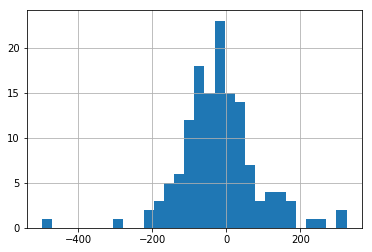

In [72]:
pd.Series((test_Y-predict*0.95)).hist(bins =30)

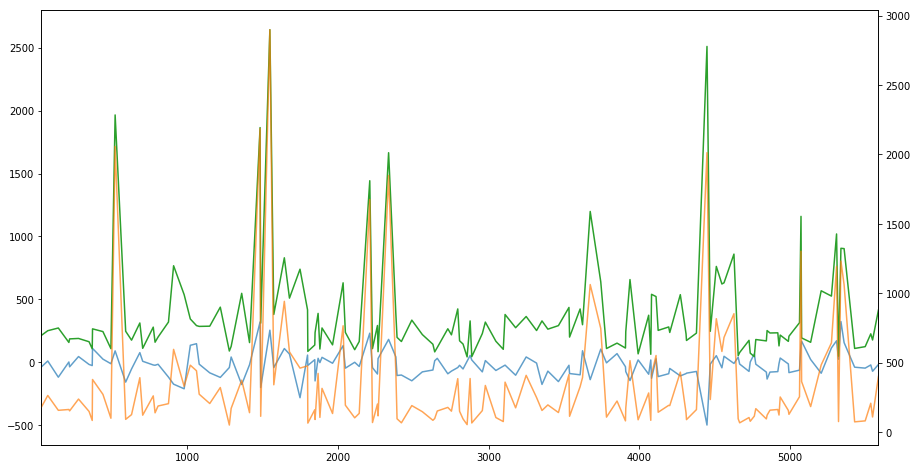

In [73]:
ax = pd.Series((test_Y-predict*0.95)).plot(figsize=(15,8),  alpha=0.7)
test_Y.plot(ax=ax, secondary_y=True, alpha=0.7)
pd.Series(predict*0.95,index=test_Y.index).plot(ax=ax)

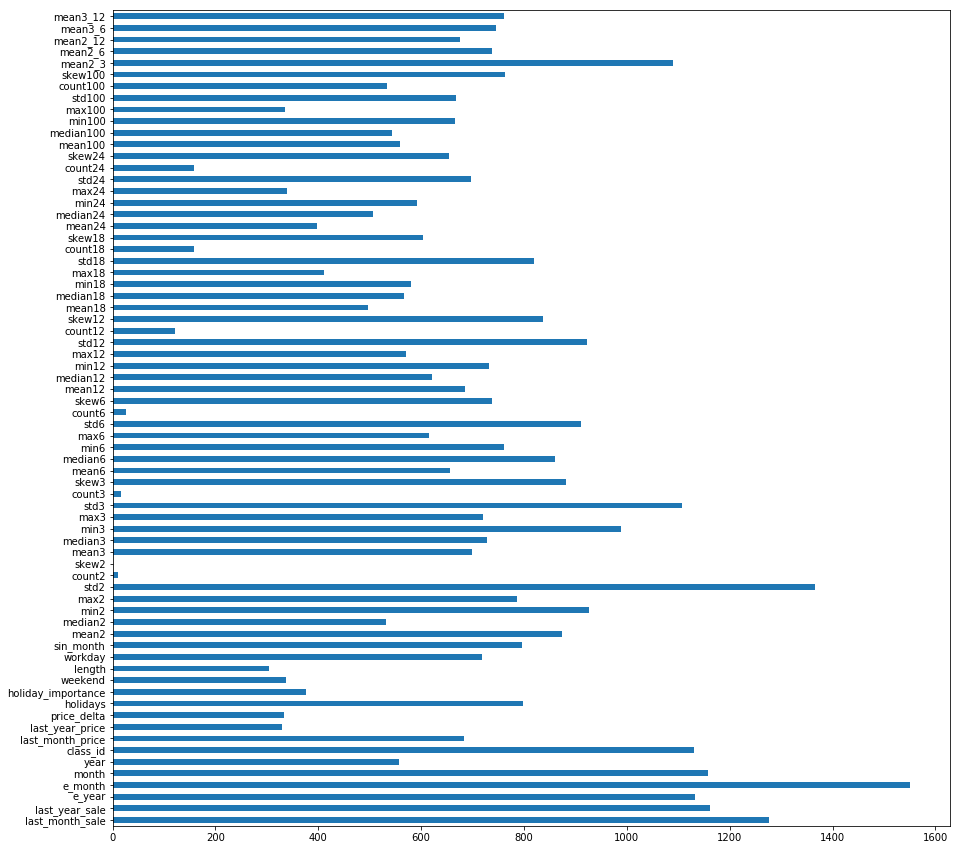

In [52]:
pd.Series(model1.feature_importances_, index=train_X.columns).plot.barh(figsize=(15,15))

## test

In [74]:
dataset_t = {}
for c in cols:
    dataset_t[c]=[]

In [75]:
count = 0
max_value = sale_class_date.max()
for c in sale_class_date.index.levels[0]:
        t = datetime.datetime(2017, 11, 1, 0, 0, 0)
        count +=1
        dataset_t['current_sale'].append(0)
        dataset_t['month'].append(t.month)
        dataset_t['year'].append(t.year)
        dataset_t['class_id'].append(c)
        dataset_t['virtual_date'].append(t)
        l3_total, l3_count = 0, 0
        
        last_month = t + DateOffset(months=-1)
        if last_month in sale_class_date[c].index:
            dataset_t['last_month_sale'].append(sale_class_date[c][last_month])
            l3_total += sale_class_date[c][last_month]
            l3_count += 1
        else:
            dataset_t['last_month_sale'].append(np.nan)
            
        last_year = t + DateOffset(years = -1)
        if last_year in sale_class_date[c].index:
            dataset_t['last_year_sale'].append(sale_class_date[c][last_year])
        else:
            dataset_t['last_year_sale'].append(np.nan)
            
        lalm = last_year + DateOffset(months = -1)
        if last_month in sale_class_date[c].index and last_year in sale_class_date[c].index and lalm in sale_class_date[c].index:
            dataset_t['e_year'].append(np.minimum(max_value,sale_class_date[c][last_month]*sale_class_date[c][last_year]/sale_class_date[c][lalm]))
        else:
            dataset_t['e_year'].append(np.nan)
            
        last_two_month = last_month + DateOffset(months = -1)
        if last_month in sale_class_date[c].index and last_two_month in sale_class_date[c].index:
            dataset_t['e_month'].append(np.minimum(max_value,sale_class_date[c][last_month]*sale_class_date[c][last_month]/sale_class_date[c][last_two_month]))
        else:
            dataset_t['e_month'].append(np.nan)
        
        if last_month in price_date[c].index:
            dataset_t['last_month_price'].append(price_date[c][last_month])
        else:
            dataset_t['last_month_price'].append(np.nan)
            
        if last_year in price_date[c].index:
            dataset_t['last_year_price'].append(price_date[c][last_year])
        else:
            dataset_t['last_year_price'].append(np.nan)
            
        dataset_t['price_delta'].append(dataset_t['last_month_price'][-1] - dataset_t['last_year_price'][-1])
        
        dataset_t['holidays'].append(holiday_df.loc[t,'holidays'])
        dataset_t['holiday_importance'].append(holiday_df.loc[t,'important'])
                
        temp = t
        weekend = 0
        length = 0
        while temp.month==t.month:
            length+=1
            if temp.weekday() >=5:
                weekend+=1
            temp += DateOffset(days=1)
        dataset_t['weekend'].append(weekend)
        dataset_t['length'].append(length)
        dataset_t['workday'].append(length-weekend-holiday_df.loc[t,'holidays'])
print(count)

140


In [76]:
test_df = pd.DataFrame(dataset_t, columns=cols)

In [77]:
test_df.columns

Index(['current_sale', 'last_month_sale', 'last_year_sale', 'e_year',
       'e_month', 'month', 'year', 'class_id', 'last_month_price',
       'last_year_price', 'price_delta', 'holidays', 'holiday_importance',
       'weekend', 'length', 'workday', 'virtual_date'],
      dtype='object')

In [78]:
test_df['virtual_date'] = test_df['virtual_date'].dt.date

In [79]:
test_df.head()

,current_sale,last_month_sale,last_year_sale,e_year,e_month,month,year,class_id,last_month_price,last_year_price,price_delta,holidays,holiday_importance,weekend,length,workday,virtual_date
0,0,180,876.0,249.493671,174.193548,11,2017,103507,10.0,13.8,-3.8,0,0,8,30,22,2017-11-01
1,0,263,301.0,270.180887,242.698246,11,2017,124140,13.5,13.3,0.2,0,0,8,30,22,2017-11-01
2,0,156,131.0,206.424242,74.195122,11,2017,125403,24.3,45.0,-20.7,0,0,8,30,22,2017-11-01
3,0,162,213.0,191.700000,180.993103,11,2017,136916,16.6,17.6,-1.0,0,0,8,30,22,2017-11-01
4,0,152,NaN,NaN,105.497717,11,2017,169673,8.0,NaN,NaN,0,0,8,30,22,2017-11-01


In [80]:
lagging_features_test = []
reset_scd = sale_class_date.reset_index()

date = datetime.date(2017,11,1)
month_feature = []
for month in [2,3,6,12,18,24,100]:
    month_feature.append(quantity_feature(reset_scd, month, date))
temp = pd.concat(month_feature, axis=1)
temp = temp.loc[:,~temp.columns.duplicated()]
lagging_features_test.append(temp.copy())
lagging_features_test_df = pd.concat(lagging_features_test, axis=0).reset_index()
lagging_features_test_df = ratio_feature(lagging_features_test_df)

/Users/olivia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


In [81]:
test_df = test_df.merge(lagging_features_test_df, left_on=['class_id','virtual_date'], right_on=['class_id','date'], 
                        how='left')

In [82]:
test_df['sin_month'] = np.sin(test_df['month']*np.pi/12)
test_df.drop(['virtual_date','date'], axis=1, inplace=True)

In [83]:
lagging_features_test_df.tail()

,class_id,mean2,median2,min2,max2,std2,count2,skew2,date,mean3,...,min100,max100,std100,count100,skew100,mean2_3,mean2_6,mean2_12,mean3_6,mean3_12
135,961362,88.5,88.5,73,104,21.920310,2,NaN,2017-11-01,97.333333,...,5,182,38.777659,70,0.768943,0.900000,0.934859,0.886477,1.028169,0.974958
136,961962,101.0,101.0,80,122,29.698485,2,NaN,2017-11-01,101.333333,...,5,450,85.248740,70,0.936636,0.986971,0.932308,0.711268,0.935385,0.713615
137,963845,224.5,224.5,207,242,24.748737,2,NaN,2017-11-01,211.666667,...,55,918,144.339970,37,2.649380,1.055643,1.078463,0.733860,1.016813,0.691910
138,973106,171.5,171.5,108,235,89.802561,2,NaN,2017-11-01,163.333333,...,10,235,61.596131,12,0.355232,1.043611,1.132013,1.464769,1.078108,1.395018
139,978089,400.5,400.5,400,401,0.707107,2,NaN,2017-11-01,406.666667,...,18,1284,224.121482,39,1.010165,0.982420,1.005860,0.814162,1.021348,0.826698


In [84]:
test_df['mean6'].sort_values()

68       37.166667
39       40.000000
114      43.833333
112      48.666667
70       50.333333
95       53.333333
115      54.166667
53       59.750000
132      64.666667
48       70.400000
27       70.833333
93       72.000000
103      77.333333
111      84.333333
135      93.666667
10       97.166667
74       97.500000
61       98.666667
43      100.333333
7       102.500000
15      104.166667
60      105.000000
136     107.333333
51      107.500000
83      108.250000
88      110.500000
121     110.833333
41      111.500000
90      113.166667
4       116.200000
          ...     
82      479.500000
36      503.000000
97      533.500000
21      540.166667
29      556.000000
101     559.000000
129     560.500000
130     567.500000
92      589.333333
26      593.833333
108     605.166667
109     614.500000
87      652.166667
37      656.166667
46      730.666667
110     763.500000
107     779.000000
20      779.166667
35      784.500000
134     871.500000
133     947.666667
86     1000.

In [108]:

train_df = data_df

train_X = data_df.drop('current_sale', axis=1)
train_Y = data_df['current_sale']
test_X = test_df.drop('current_sale', axis=1)
predictor = train_X.columns.tolist()
predict = 0
bagging_num = 1
for i in range(bagging_num):
    model1 = LGBMRegressor(learning_rate=0.015, n_estimators=1600, subsample=0.8, num_leaves=30+i, 
                           colsample_bytree=0.4, min_child_samples=20, reg_lambda=0.0001, random_seed=i)
    model2 = CatBoostRegressor(iterations=1400, learning_rate=0.01, depth=6, random_seed=i,
                               l2_leaf_reg=4, loss_function='RMSE', eval_metric='RMSE',logging_level='Silent')
    
    model1.fit(train_X[predictor].fillna(-99999), (train_Y))
    model2.fit(train_X[predictor].fillna(-99999), np.log10(train_Y), cat_features=[6])
    predict += model1.predict(test_X[predictor].fillna(-99999)) 
    predict += np.power(10, model2.predict(test_X[predictor].fillna(-99999)))
predict = predict/bagging_num/2

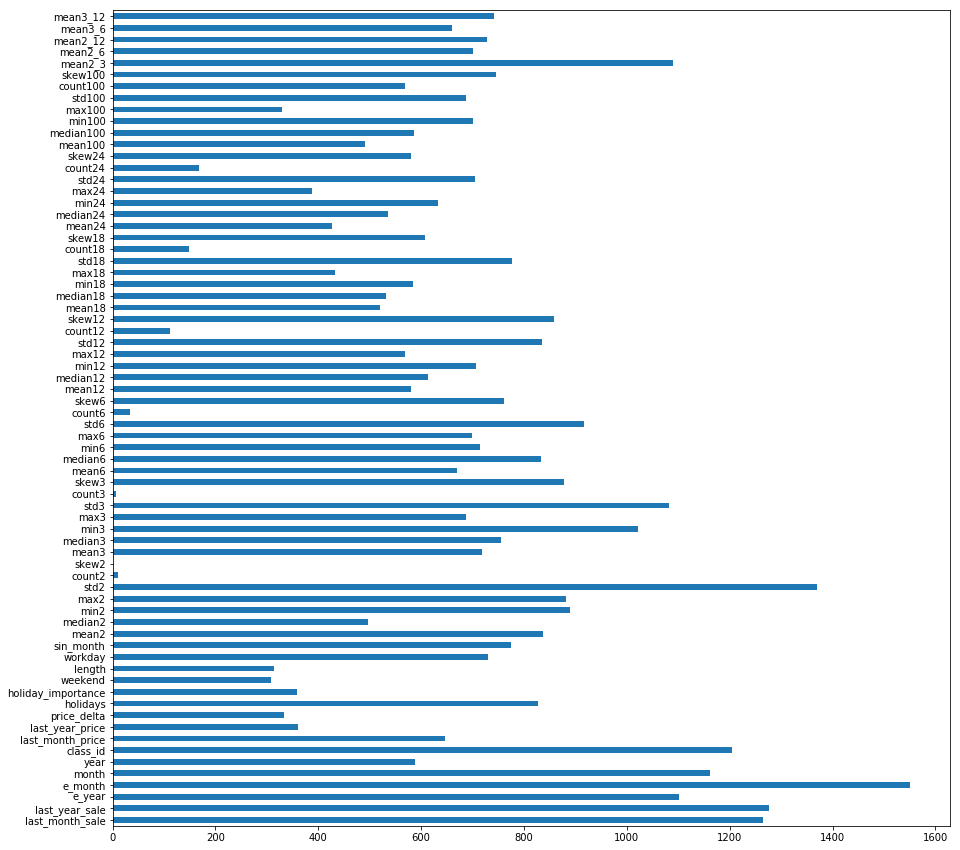

In [109]:
pd.Series(model1.feature_importances_, index=train_X[predictor].columns).plot.barh(figsize=(15,15))

In [110]:
test_X.head()

,last_month_sale,last_year_sale,e_year,e_month,month,year,class_id,last_month_price,last_year_price,price_delta,...,max100,std100,count100,skew100,mean2_3,mean2_6,mean2_12,mean3_6,mean3_12,sin_month
0,180,876.0,249.493671,174.193548,11,2017,103507,10.0,13.8,-3.8,...,1653,374.166890,32,1.372849,1.000000,0.659459,0.378947,0.655856,0.376877,0.258819
1,263,301.0,270.180887,242.698246,11,2017,124140,13.5,13.3,0.2,...,526,91.739079,42,0.014611,1.057915,1.057915,0.986203,0.996139,0.928614,0.258819
2,156,131.0,206.424242,74.195122,11,2017,125403,24.3,45.0,-20.7,...,418,75.993625,70,1.200444,0.909774,0.788702,0.921905,0.863661,1.009524,0.258819
3,162,213.0,191.700000,180.993103,11,2017,136916,16.6,17.6,-1.0,...,715,132.871645,70,1.129576,0.941718,0.925628,0.826380,0.976884,0.872140,0.258819
4,152,NaN,NaN,105.497717,11,2017,169673,8.0,NaN,NaN,...,219,68.349835,5,1.015397,1.209783,1.582765,1.582765,1.299772,1.299772,0.258819


In [111]:
data_df[(data_df['class_id']==103507) & (data_df['month']==11)]

,current_sale,last_month_sale,last_year_sale,e_year,e_month,month,year,class_id,last_month_price,last_year_price,...,min100,max100,std100,count100,skew100,mean2_3,mean2_6,mean2_12,mean3_6,mean3_12
8,481,1050.0,NaN,NaN,2494.343891,11,2015,103507,12.9,NaN,...,58.0,1050.0,296.959232,8.0,2.044435,1.209730,1.681443,2.020311,1.387678,1.667344
20,876,632.0,481.0,289.51619,583.953216,11,2016,103507,13.8,10.0,...,58.0,1433.0,355.131984,20.0,0.770980,1.144348,1.065012,0.943595,0.929053,0.823136


In [112]:
predict

array([ 211.39359654,  277.02011877,  210.02700997,  169.73946534,
        177.57509631,  242.60251941,  166.24506949,  106.5480432 ,
        441.13763281,  255.06432633,  114.69959601, 2371.68140976,
        189.00748471,  176.13837602,  388.099591  ,  130.4970912 ,
        285.98377367,  165.38022523,  197.05227932,  243.96393927,
        740.42077765,  427.21261125,  471.64148501,  412.92021687,
        293.62733853,  236.75296969,  383.63646683,   77.07100911,
        162.43927787,  443.75194258,  148.45279743, 2413.98584334,
        211.10216007, 3225.90363863,  353.32314353,  931.34933595,
        577.58133599,  620.52833888,  477.32831861,  104.1868396 ,
        156.48308156,  168.81121399,  440.03011189,  116.24490605,
        346.95151933,  129.50518959,  685.70945678,  238.35795938,
        111.76017757,  154.74113925, 1897.01036801,   96.50013218,
        250.45132361,  120.61044153, 2092.56930515,  437.9348161 ,
        141.76816585,  118.61825136,  272.9592927 ,  181.34630

In [113]:
predict1 = predict*0.95

In [114]:
predict1

array([ 200.82391671,  263.16911283,  199.52565947,  161.25249208,
        168.6963415 ,  230.47239344,  157.93281602,  101.22064104,
        419.08075117,  242.31111001,  108.96461621, 2253.09733928,
        179.55711047,  167.33145722,  368.69461145,  123.97223664,
        271.68458499,  157.11121397,  187.19966535,  231.7657423 ,
        703.39973877,  405.85198069,  448.05941076,  392.27420603,
        278.9459716 ,  224.91532121,  364.45464349,   73.21745866,
        154.31731398,  421.56434545,  141.03015756, 2293.28655117,
        200.54705207, 3064.6084567 ,  335.65698636,  884.78186915,
        548.70226919,  589.50192194,  453.46190268,   98.97749762,
        148.65892748,  160.37065329,  418.02860629,  110.43266075,
        329.60394336,  123.02993011,  651.42398395,  226.44006141,
        106.1721687 ,  147.00408229, 1802.15984961,   91.67512557,
        237.92875743,  114.57991945, 1987.94083989,  416.03807529,
        134.67975756,  112.68733879,  259.31132807,  172.27899

In [119]:
ans_df = pd.DataFrame()

ans_df['class_id']=test_df['class_id']
ans_df['predict_date']='201712'
ans_df['predict_quantity']=predict1.astype(np.int)

ans_df.set_index('class_id',inplace=True)
ans_df.sort_index(inplace=True)

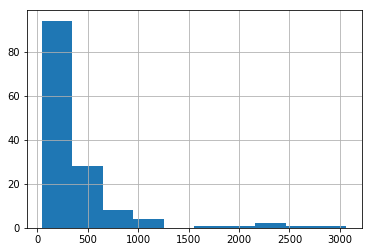

In [120]:
ans_df['predict_quantity'].hist()

In [121]:
ans_df.to_csv('predict_0227.csv')

In [101]:
ans_df['predict_quantity'].isnull().sum()

0

In [102]:
ans_df['predict_quantity'].sum()

53137

In [117]:
mse = mean_squared_error(test_Y.values, predict1)
print(np.sqrt(mse))

70.78135799526291


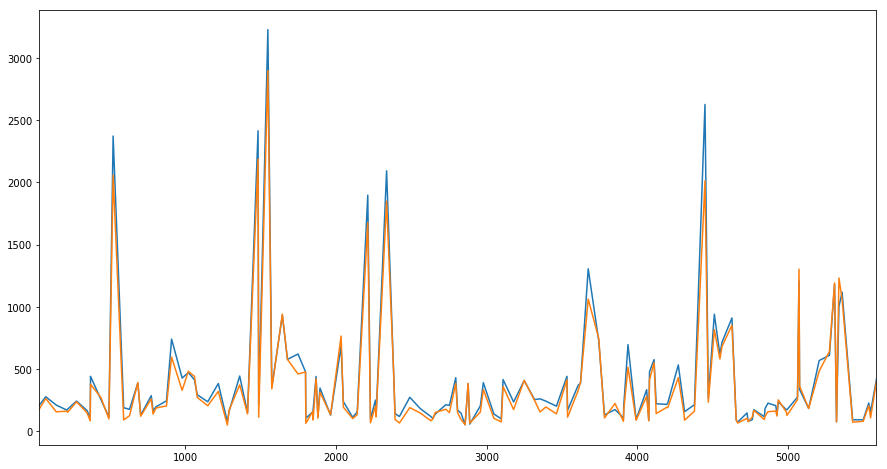

In [125]:
pd.Series(predict,index=test_Y.index).plot(figsize=(15,8))
pd.Series(test_Y).plot()